# Starter Kit: StepUP P150 - Dataset Competition

This notebook provides example code for the StepUP P150 Dataset Competition at IJCB 2025

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pathlib
import itertools
import zipfile
import os

# Specify Dataset Filepaths

Before running this notebook, download the [competition dataset](https://unbcloud-my.sharepoint.com/my?id=%2Fpersonal%2Fq4k8p%5Funb%5Fca%2FDocuments%2FPermalinks%2FIJCB%202025%20Dataset%20Competition%20%2D%20Footstep%20Recognition&ga=1) and update the filepath below.

In [4]:
# TODO: Update this filepath for your environment.
dataset_root = pathlib.Path('/mnt/c/Users/aaron/OneDrive - University of New Brunswick/Permalinks/IJCB 2025 Dataset Competition - Footstep Recognition')


pretraining_dataset = dataset_root / '1 - StepUP-P150'
gallary_dataset = dataset_root / '2 - Gallery'
probe_dataset = dataset_root / '3 - Probe'

# Confirm that the dataset folders exist before contining.
# If this results in an error, double check that you have downloaded and extracted the dataset successfully and correctly updated the filepath above.
for filepath in [pretraining_dataset, gallary_dataset, probe_dataset]:
  assert(filepath.exists())

# Phase 1: Model Pretraining

In this competition, the StepUP-P150 dataset will be used to pretrain a model for footstep verification.

This section provides example code for data loading and model pretraining.

## Load Metadata

In [5]:
# A function to load metadata for StepUP-P150 trial(s). Loads metadata for entire dataset by default, but can be filtered as desired.
# Arguments should be provided as lists, even when they contain only a single value (e.g., speeds = ['W1'])
# 
# Returns a pandas.Dataframe, which can be used to filter the footstep samples used for model training in the data loader, below. 

participant_ids = range(1, 151)
footwears = 'BF ST P1 P2'.split()
speeds = 'W1 W2 W3 W4'.split()


def load_metadata(participant_ids=participant_ids, footwears=footwears, speeds=speeds):
  dfs = []

  for p, f, s in itertools.product(participant_ids, footwears, speeds):
    filename = pretraining_dataset / f'{p:03}' / f / s / 'metadata.csv'
    dfs.append(pd.read_csv(filename))

  return pd.concat(dfs).reset_index(drop=True)

In [6]:
# To make this example script run quickly, we're only loading the first 10 participants
# Remove the `participant_ids` argument below to load metadata for the entire dataset.

metadata = load_metadata(participant_ids=range(1, 11))
metadata.shape

(14056, 22)

In [7]:
metadata.head()

,ParticipantID,Footwear,Speed,FootstepID,PassID,StartFrame,EndFrame,Ymin,Ymax,Xmin,...,Side,Standing,Incomplete,Rscore,Outlier,Exclude,RotationAngle,FootLength,FootWidth,MeanGRF
0,1,BF,W1,0,0,212,288,76,131,167,...,Right,0,0,0.248545,0,0,4.246666,53.0,19.0,23270.396040
1,1,BF,W1,1,0,276,348,233,291,191,...,Left,0,0,1.126682,0,0,1.618202,55.0,20.0,25024.029703
2,1,BF,W1,2,0,331,407,385,439,167,...,Right,0,0,0.511779,0,0,4.133031,53.0,19.0,19953.871287
3,1,BF,W1,3,0,393,469,537,593,189,...,Left,0,0,0.188634,0,0,3.611146,55.0,18.0,20826.940594
4,1,BF,W1,4,0,454,498,689,710,183,...,Right,0,1,7.175712,1,1,22.316611,21.0,13.0,70282.683168


## Filter Metadata

In [8]:
# In our baseline model, we've chosen to omit all `walk_speed == W2` footstep records, as well as all those recommended for exclusion by the StepUP authors (see paper for details)

filtered_metadata = metadata.query('Speed != "W2" and Exclude == False')
filtered_metadata.shape

(9841, 22)

## Create Data Loader

In [26]:
def load_footstep(participant_id, footwear, speed, footstep_id):
  npz_file = pretraining_dataset / f'{participant_id:03}' / footwear / speed / 'pipeline_1.npz'
  return np.load(npz_file)[str(footstep_id)]

(101, 75, 40)

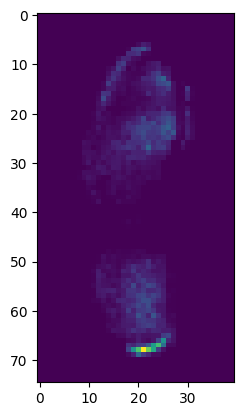

In [27]:
d = load_footstep(100, 'ST', 'W3', 70)
plt.imshow(d.max(axis=(0)))
d.shape

## Train Model

# Phase 2: User Enrolment

# Phase 3: Verification Attempts

In [12]:
predictions = np.random.random((10000))
threshold = np.array([0.65])

# Prepare CodaBench Submission

In [13]:
# This function packages your model predictions into a format suitable for submission on CodaBench.
#
#  - predictions: (10000,) element numpy array in range [0.0,1.0] 
#  - decision threshold: (1,) element numpy array in range [0.0, 1.0]
#  - output: (optional) filename of created zipfile

def package_predictions_for_submission(predictions, decision_threshold, output=pathlib.Path('./submission.zip')):
  
  filename_variable_pairs = {
    'thresholds.txt': decision_threshold,
    'predictions.txt': predictions,
  }

  # The most straightforward way to populate a zip file is with actual files on disk
  # Therefore, temporarily create each file in the working directory  
  for f, d in filename_variable_pairs.items():
    np.savetxt(f, d)

  # Create the zip file
  with zipfile.ZipFile(output, mode='w') as z:
    for f, _ in filename_variable_pairs.items():
      z.write(f)
  
  # ...the cleanup after ourselves to avoid clutter
  for f, _ in filename_variable_pairs.items():
    os.remove(f)

  print(f'Successfully created CodaBench submission file: `{output}`. Upload this zipfile to CodaBench to complete your submission')

In [14]:
package_predictions_for_submission(predictions, threshold)

Successfully created CodaBench submission file: `submission.zip`. Upload this zipfile to CodaBench to complete your submission
